In [192]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 100)

# Basic CSV loading
try:
    brands_raw = pd.read_csv('/Users/gholamreza/Documents/Bootcamp/Primer/Pandas/brands.csv')
    orders_raw = pd.read_csv('/Users/gholamreza/Documents/Bootcamp/Primer/Pandas/orders.csv')
    products_raw = pd.read_csv('/Users/gholamreza/Documents/Bootcamp/Primer/Pandas/products.csv')
    orderlines_raw = pd.read_csv('/Users/gholamreza/Documents/Bootcamp/Primer/Pandas/orderlines.csv')
    
    #Make working copies (so we don’t touch raw data)
    products   = products_raw.copy()
    orders     = orders_raw.copy()
    orderlines = orderlines_raw.copy()
    brands     = brands_raw.copy()
    
    #Checkind the files info
    print(products.info())
    print(orders.info())
    print(orderlines.info())
    print(brands.info())
    
    duplicate_rows = products[products.duplicated()]
    print(duplicate_rows)
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all files are uploaded correctly.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          19326 non-null  object
 1   name         19326 non-null  object
 2   desc         19319 non-null  object
 3   price        19280 non-null  object
 4   promo_price  19326 non-null  object
 5   in_stock     19326 non-null  int64 
 6   type         19276 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226909 non-null  int64  
 1   created_date  226909 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226909 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB
None
<class 'pandas.core.frame.D

## Observations from your `info()` outputs

### `products.csv`
- `price` and `promo_price` are **object** → must convert to **float**.  
- `type` has ~50 missing values.  
- `desc` has 7 missing values (probably safe to ignore).  
- ✅ Good: `sku` is complete.  

### `orders.csv`
- `created_date` is **object** → convert to **datetime**.  
- `total_paid` has 5 missing values (decision: drop or fill).  
- `state` is categorical.  

### `orderlines.csv`
- `unit_price` is **object** → must convert to **numeric**.  
- `date` is **object** → convert to **datetime**.  
- `id_order` is the foreign key to `orders.order_id`.  
- `sku` joins to `products.sku`.  

### `brands.csv`
- Looks fine, just a lookup table (short → long brand names).  
- We might merge it into `products` if needed.
-  


In [193]:
# --- Products ---

products = products.drop_duplicates(subset=['sku'], keep='first')  # removes duplicate rows

for col in ['price', 'promo_price']:
    products[col] = (
        products[col]
        .astype(str)
        .str.replace(r'\.', '', regex=True)  # First remove all periods (thousand separators)
        .str.replace(r',', '.')  # Then convert commas to periods (decimal separator)
        .str.replace(r'[^0-9.]', '', regex=True)  # Remove any other non-numeric characters
        .replace('', None)
        .astype(float)
    )

# Fill missing product type (temporary placeholder)
products['type'] = products['type'].fillna("Unknown")

# --- Orders ---
orders = orders.loc[~orders.total_paid.isna(), :]
orders['created_date'] = pd.to_datetime(orders['created_date'], errors='coerce')

# Handle missing total_paid (drop them)
orders = orders.dropna(subset=['total_paid'])

# --- Orderlines ---
#orderlines['unit_price'] = (
#    orderlines['unit_price']
#    .astype(str)
#    .str.replace(r'\.', '', regex=True)  # First remove all periods (thousand separators)
#   .str.replace(r',', '.')  # Then convert commas to periods (decimal separator)
#   .str.replace(r'[^0-9.]', '', regex=True)  # Remove any other non-numeric characters
#    .replace('', None)
#    .astype(float)
#)
two_dot_order_ids_list = orderlines.loc[orderlines.unit_price.str.contains("\d+\.\d+\.\d+"), "id_order"]
orderlines = orderlines.loc[~orderlines.id_order.isin(two_dot_order_ids_list)]
orderlines['date'] = pd.to_datetime(orderlines['date'], errors='coerce')

print(products.info())
print(orders.info())
print(orderlines.info())
print(brands.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10579 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sku          10579 non-null  object 
 1   name         10579 non-null  object 
 2   desc         10572 non-null  object 
 3   price        10534 non-null  float64
 4   promo_price  10579 non-null  float64
 5   in_stock     10579 non-null  int64  
 6   type         10579 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 661.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 226904 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      226904 non-null  int64         
 1   created_date  226904 non-null  datetime64[ns]
 2   total_paid    226904 non-null  float64       
 3   state         226904 non-null  object        
dtypes: datetime64[ns](1), float64(1), 

## Product types are not meaningfull to create categories:

In [194]:
#checking the orders status.
orders.groupby("state").count()

,order_id,created_date,total_paid
state,,,
Cancelled,7233,7233,7233
Completed,46605,46605,46605
Pending,14374,14374,14374
Place Order,40883,40883,40883
Shopping Basket,117809,117809,117809


In [195]:
#keep only completed orders in new DF
completed_orders = orders[orders["state"] == "Completed"]
completed_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46605 entries, 1 to 226619
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      46605 non-null  int64         
 1   created_date  46605 non-null  datetime64[ns]
 2   total_paid    46605 non-null  float64       
 3   state         46605 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [196]:
orderlines.id_order.nunique()

170213

In [197]:
orders_orderlines = completed_orders.merge(orderlines, how="inner", left_on="order_id", right_on="id_order")

In [198]:
# order_ids that are in both tables
order_ids = orders_orderlines["order_id"].unique()

In [201]:
# keep those ids in orders
orders = orders.loc[orders["order_id"].isin(order_ids), :]

# keep those ids in orderlines
orderlines = orderlines.loc[orderlines["id_order"].isin(order_ids), :]

In [202]:
orders["order_id"].nunique(), orderlines["id_order"].nunique()

(43064, 43064)

In [203]:
orderlines_copy=orderlines.copy()
orders_copy=orders.copy()

In [204]:
#Create the unit_price_total as orderlines.unit_price * orderlines.product_quantity
orderlines_copy["unit_price_total"] = orderlines_copy["product_quantity"] * orderlines_copy["unit_price"]
orderlines_copy.tail(10)

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
293583,1649440,527035,0,1,APP0498,23.00,2018-03-14 11:41:55,23.00
293584,1649441,527034,0,1,APP0927,13.99,2018-03-14 11:42:01,13.99
293586,1649446,527042,0,1,APP0927,13.99,2018-03-14 11:42:38,13.99
293587,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99
293596,1649468,525664,0,1,TUC0336,7.93,2018-03-14 11:43:59,7.93
293599,1649474,525664,0,1,TUC0207,16.52,2018-03-14 11:45:05,16.52
293616,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,9.999.99
293621,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,9.999.99
293644,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,9.999.999.99
293661,1649593,527112,0,1,APP0698,9.99,2018-03-14 11:58:13,9.99


In [205]:
#Group by id_order, summarising by the sum of unit_price_total
orderlines_order_ids = orderlines_copy.groupby("id_order", as_index=False)["unit_price_total"].sum()
# as_index=False changes the return so that the groupedby column remains a column (not the index)
orderlines_order_ids

,id_order,unit_price_total
0,241423,129.16
1,242832,10.77
2,243330,77.99
3,245275,149.00
4,245595,52.9952.99
...,...,...
43059,527042,13.99
43060,527070,9.999.99
43061,527074,9.999.99
43062,527096,9.999.999.99


In [206]:
#merge our grouped orderlines table with the orders table, so we can calculate the differences in prices.
diff_df = orders_copy.merge(orderlines_order_ids, left_on="order_id", right_on="id_order")
diff_df["difference"] = diff_df["total_paid"] - pd.to_numeric(diff_df["unit_price_total"], errors="coerce")

diff_df.head(10)

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,52.9952.99,NaN
5,246018,2017-02-13 23:02:57,211.95,Completed,246018,93.9924.997.9979.99,NaN
6,246405,2017-11-24 10:01:27,407.96,Completed,246405,121.9118.5989.3545.90,NaN
7,247524,2018-01-09 14:21:34,167.98,Completed,247524,162.99,4.99
8,247643,2017-05-26 11:50:35,153.54,Completed,247643,153.54,0.00
9,250275,2017-11-19 22:34:54,54.99,Completed,250275,51.00,3.99


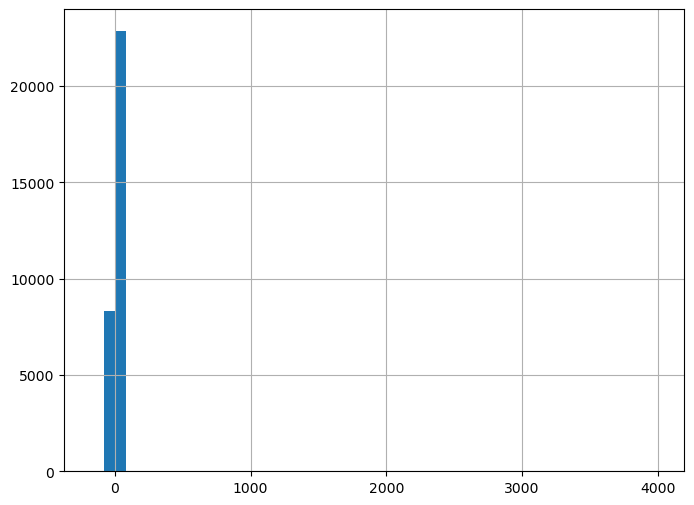

In [207]:
#the distribution of these differences
diff_df.difference.hist(bins= 50, figsize=(8,6));

In [208]:
#some of the difference must be due to corruption. Let's use .describe() to investigate the distribution further.
diff_df.difference.describe()

count   31142.00
mean        4.42
std        27.10
min      -165.00
25%         0.00
50%         4.99
75%         6.99
max      3984.99
Name: difference, dtype: float64

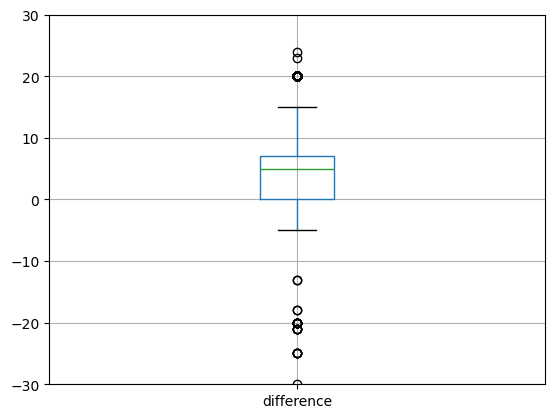

In [209]:
#There's a rule of thumb, that anything:

#lower than the 25% quartile - (1.5 x interquartile range), or
#higher than the 75% quartile + (1.5 x interquartile range)
#is an outlier. Let's use this rule to try and exclude any corrupted data.

import matplotlib.pyplot as plt

ax = diff_df.boxplot("difference");
ax.set_ylim(-30, +30)
plt.show()

In [210]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

Q1, Q3

(np.float64(0.0), np.float64(6.989999999999981))

In [211]:
# calculate the interquartile range
IQR = Q3-Q1
IQR

np.float64(6.989999999999981)

In [212]:
# upper boundary
Q3 + 1.5*IQR

np.float64(17.47499999999995)

In [213]:
# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[
    (diff_df["difference"] >= (Q1 - 1.5*IQR))
    &
    (diff_df["difference"] <= (Q3 + 1.5*IQR))
    ,
    :]

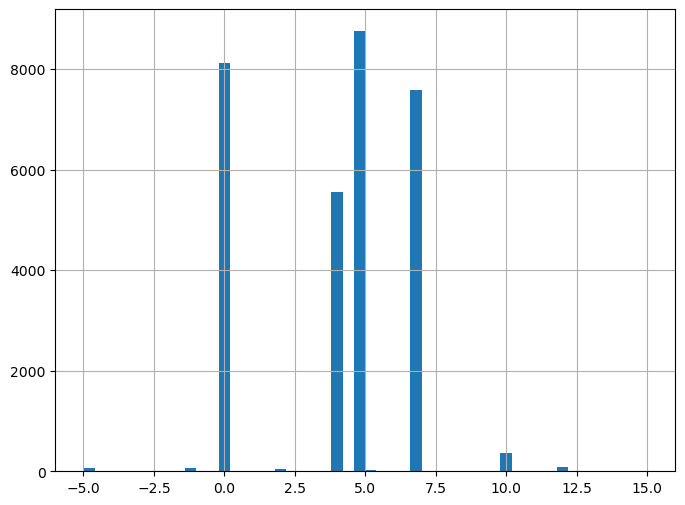

In [214]:
#check distribution again to see the effect of removing the outliers
diff_no_outliers_df.difference.hist(bins= 50, figsize=(8,6));

<Axes: >

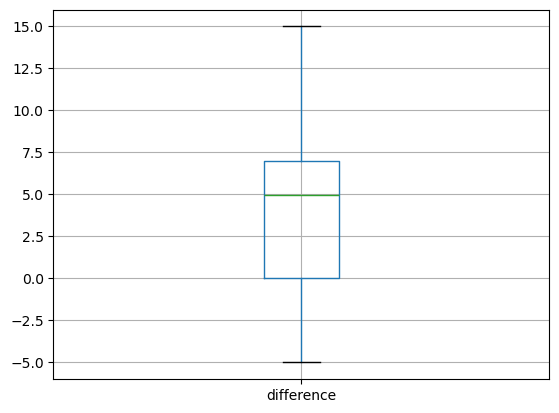

In [215]:
diff_no_outliers_df.boxplot("difference")

In [223]:
# Category creation
# Add a check for NaN values in the str.contains() method
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("mouse|trackpad", case=False), "category"] += ", mouse"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("stand|support", case=False), "category"] += ", stand"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("strap|armband|belt|bracelet", case=False), "category"] += ", strap"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("^.{0,6}apple watch|smartwatch|smart watch", case=False), "category"] += ", smartwatch"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("adapter", case=False), "category"] += ", adapter"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("^.{0,7}ram", case=False), "category"] += ", ram"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("protect|cover|sleeve|screensaver|shell", case=False), "category"] += ", protection"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("nas|server|raid|synology", case=False), "category"] += ", server"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("scale", case=False), "category"] += ", scale"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("thermometer", case=False), "category"] += ", thermometer"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("monitor", case=False), "category"] += ", monitor"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("speaker|music system", case=False), "category"] += ", speaker"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("camera", case=False), "category"] += ", camera"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("pointer", case=False), "category"] += ", pointer"
product_category_df.loc[product_category_df["desc"].fillna("").str.contains("refurbished|reconditioned|like new", case=False), "category"] += ", refurbished"

product_category_df.loc[product_category_df["category"] == "", "category"] += ", other"
product_category_df.head(10)

,sku,name,desc,price,promo_price,in_stock,type,category
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,5999.00,499899.00,1,8696,", stand, stand"
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,589996.00,0,13855401,", other"
2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,569898.00,0,1387,", mouse, mouse"
3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,229997.00,0,1230,", other"
4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pr...,3499.00,3199.00,1,1364,", ram, ram"
5,APP0073,Apple Composite AV Cable iPhone and iPod white,IPhone and iPod AV Cable Dock to Composite Video.,45.00,420003.00,0,1230,", other"
6,KIN0008,Mac Memory Kingston 1GB 667MHz DDR2 SO-DIMM,1GB RAM Mac mini and iMac (2006/07) MacBook Pr...,1899.00,146471.00,0,1364,", ram, ram"
7,KIN0009,Mac Memory Kingston 2GB 800MHz DDR2 SO-DIMM,2GB RAM iMac with Intel Core 2 Duo (Penryn).,3699.00,274694.00,0,1364,", ram, ram"
8,KIN0001-2,Mac memory Kingston 4GB (2x2GB) 667MHz DDR2 SO...,RAM 4GB (2x2GB) Mac mini and iMac (2006/07) Ma...,74.00,669904.00,0,1364,", ram, ram"
9,APP0100,Apple Adapter Mini Display Port to VGA,Adapter Mini Display Port to VGA MacBook and M...,35.00,330003.00,0,1325,", adapter, adapter"


In [228]:
# after cleaning price column to numeric
cat_stats =product_category_df.groupby('category')['price'].agg(['count','mean','median','std','min','max'])
cat_stats.head()

,count,mean,median,std,min,max
category,,,,,,
", adapter, adapter",321,64205.79,3399.00,495010.12,5.00,6999003.00
", adapter, camera, adapter, camera",4,40.00,40.00,5.77,35.00,45.00
", adapter, camera, refurbished, adapter, camera, refurbished",1,35.00,35.00,NaN,35.00,35.00
", adapter, monitor, adapter, monitor",1,799.00,799.00,NaN,799.00,799.00
", adapter, refurbished, adapter, refurbished",22,17986.68,52.00,74273.27,25.00,349932.00


array([[<Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'mean'}>],
       [<Axes: title={'center': 'median'}>,
        <Axes: title={'center': 'std'}>],
       [<Axes: title={'center': 'min'}>, <Axes: title={'center': 'max'}>]],
      dtype=object)

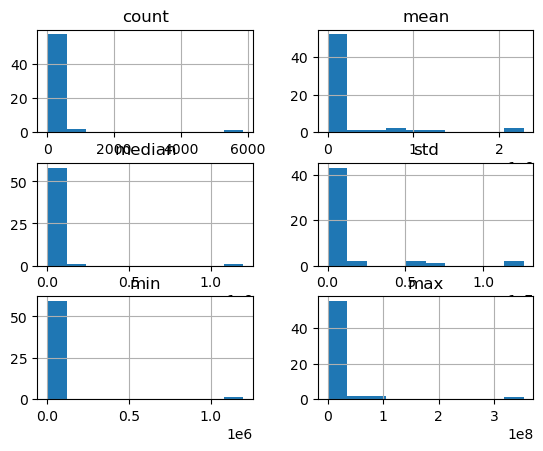

In [229]:
cat_stats.hist()

In [232]:
# 4. How many products are being discounted?
discounted_products = products_classified[products_classified['promo_price'] < products_classified['price']]
num_discounted = discounted_products.shape[0]
print(f"\nNumber of products being discounted: {num_discounted}")



Number of products being discounted: 899


In [231]:
#How big are the offered discounts (as percentage of price)?
valid = products[(products['price'].notna()) & (products['promo_price'].notna()) & (products['promo_price'] < products['price'])]
valid['discount_pct'] = (valid['price'] - valid['promo_price']) / valid['price'] * 100
valid['discount_pct'].describe()  

/var/folders/f3/wgyvp2857s1bhyr9s_rrcsc00000gn/T/ipykernel_48004/3194244171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['discount_pct'] = (valid['price'] - valid['promo_price']) / valid['price'] * 100


count   899.00
mean     33.89
std      33.00
min       0.11
25%      10.28
50%      20.35
75%      41.00
max     100.00
Name: discount_pct, dtype: float64

Products total: 10579
Products discounted: 899 (8.50%)


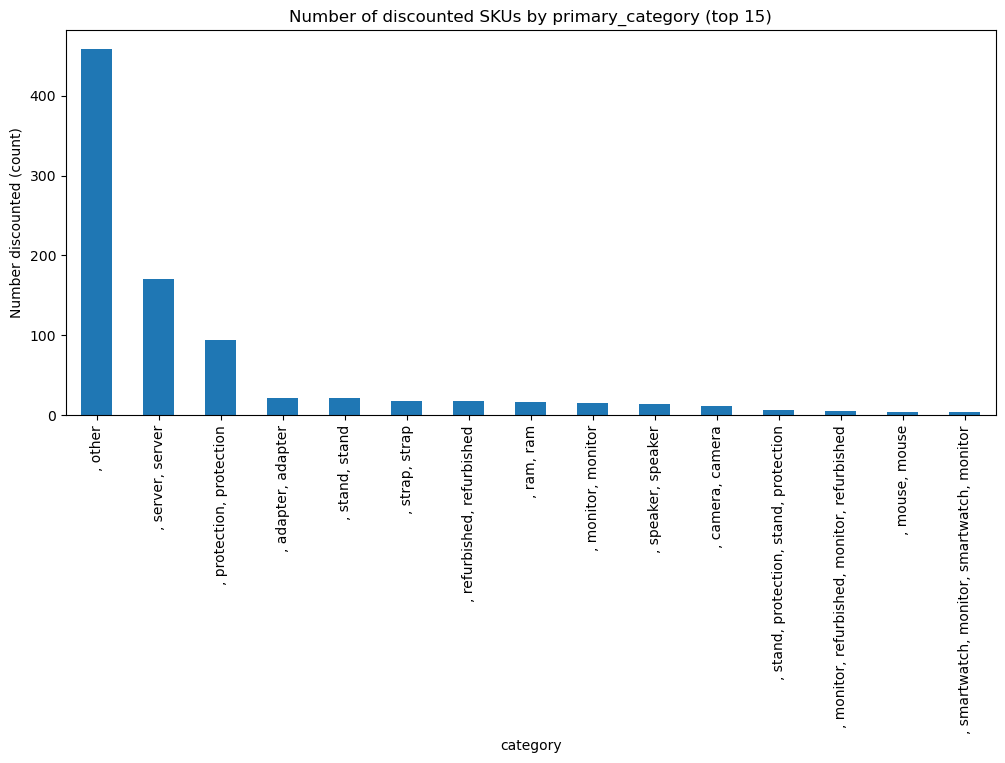

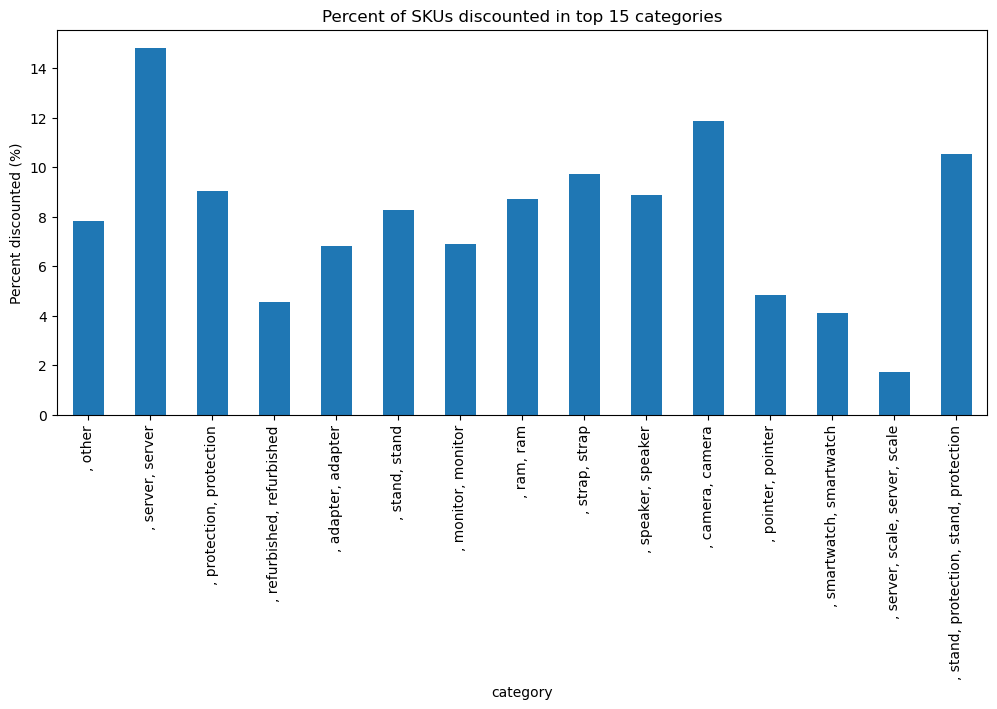

In [244]:
# discounted boolean
product_category_df['is_discounted'] = (product_category_df['promo_price'].notna()) & (product_category_df['price'].notna()) & (product_category_df['promo_price'] < product_category_df['price'])

total_products = product_category_df.shape[0]
num_discounted = product_category_df['is_discounted'].sum()
pct_discounted = num_discounted / total_products * 100

print(f"Products total: {total_products}")
print(f"Products discounted: {num_discounted} ({pct_discounted:.2f}%)")

# discounted by category (top categories)
discount_by_cat = product_category_df.groupby('category')['is_discounted'].agg(['sum','count'])
discount_by_cat['pct_discounted'] = discount_by_cat['sum'] / discount_by_cat['count'] * 100
discount_by_cat = discount_by_cat.sort_values('sum', ascending=False)
discount_by_cat.head(20)

# visualization: number of discounted SKUs per primary category
plt.figure(figsize=(12,5))
discount_by_cat['sum'].nlargest(15).plot(kind='bar')
plt.title('Number of discounted SKUs by primary_category (top 15)')
plt.ylabel('Number discounted (count)')
plt.show()

# visualization: percent discounted in each category (top 15 by count)
plt.figure(figsize=(12,5))
(top_counts := discount_by_cat.sort_values('count', ascending=False).head(15))['pct_discounted'].plot(kind='bar')
plt.title('Percent of SKUs discounted in top 15 categories')
plt.ylabel('Percent discounted (%)')
plt.show()

count   899.00
mean     33.89
std      33.00
min       0.11
25%      10.28
50%      20.35
75%      41.00
max     100.00
Name: discount_pct, dtype: float64


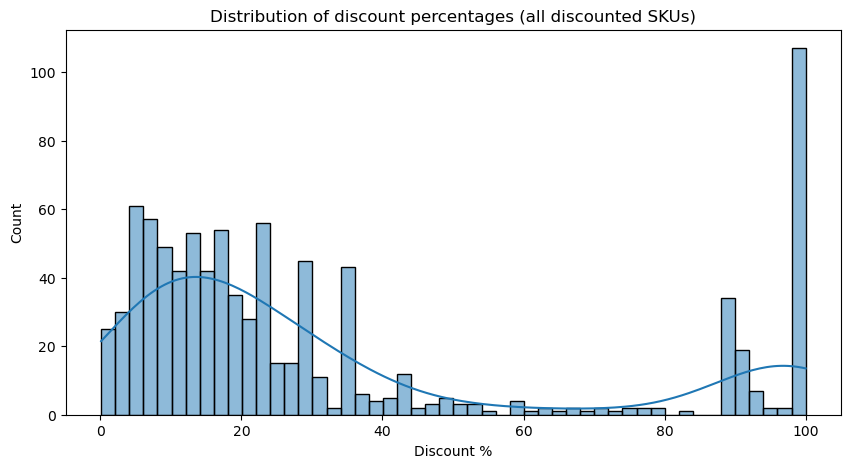

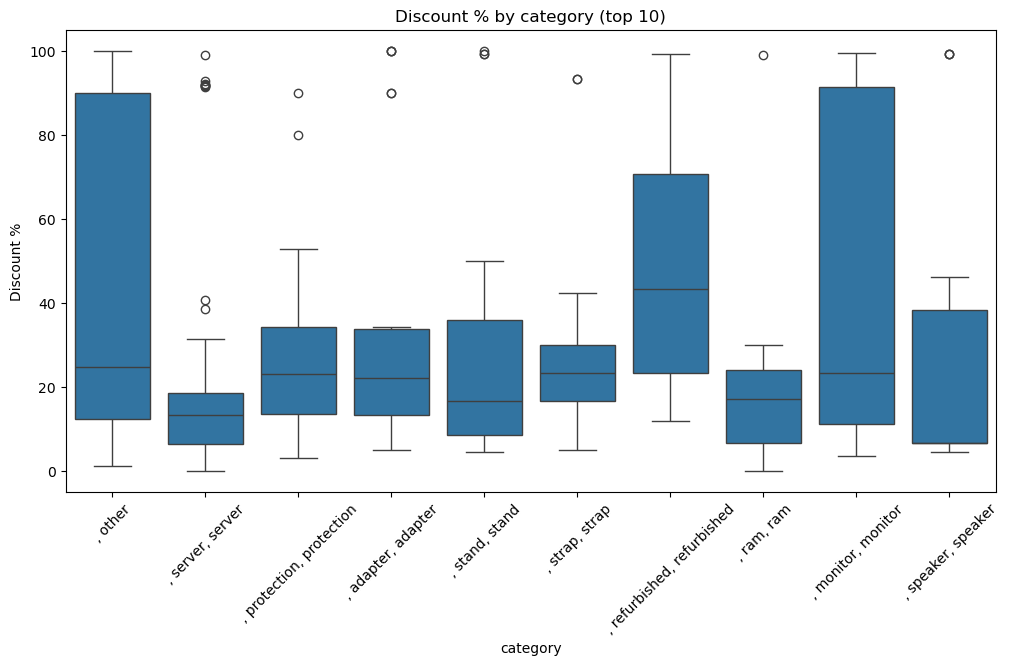

In [247]:
valid = product_category_df.loc[product_category_df['is_discounted'], :].copy()
valid['discount_pct'] = (valid['price'] - valid['promo_price']) / valid['price'] * 100

# summary
print(valid['discount_pct'].describe())

# histogram of discount %
plt.figure(figsize=(10,5))
sns.histplot(valid['discount_pct'], bins=50, kde=True)
plt.title('Distribution of discount percentages (all discounted SKUs)')
plt.xlabel('Discount %')
plt.show()

# boxplot by primary_category for top categories with discounts
discounted_topcats = valid['category'].value_counts().nlargest(10).index.tolist()
plt.figure(figsize=(12,6))
sns.boxplot(data=valid[valid['category'].isin(discounted_topcats)],
            x='category', y='discount_pct', order=discounted_topcats)
plt.title('Discount % by category (top 10)')
plt.ylabel('Discount %')
plt.xticks(rotation=45)
plt.show()

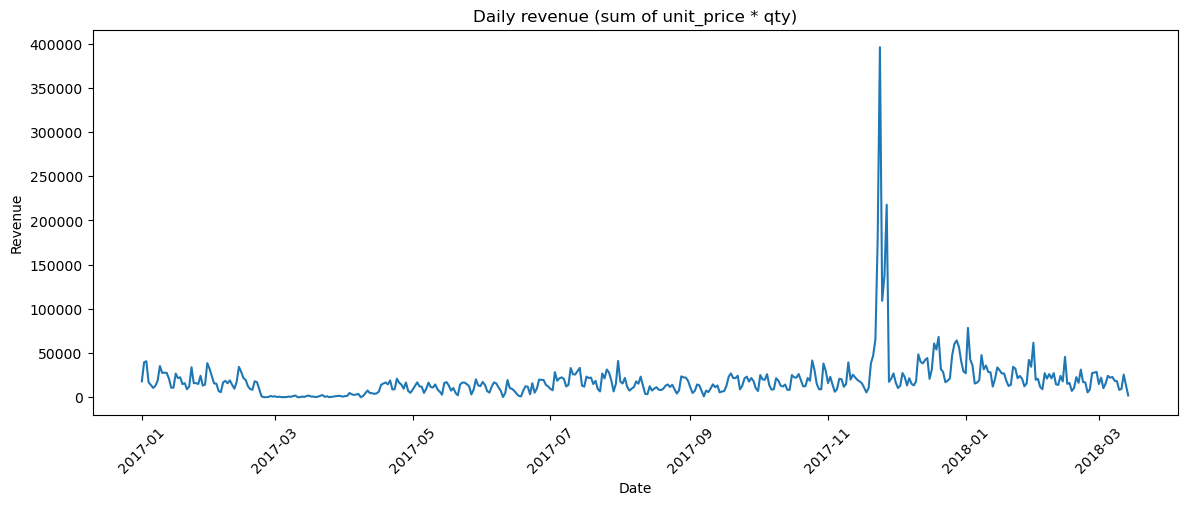

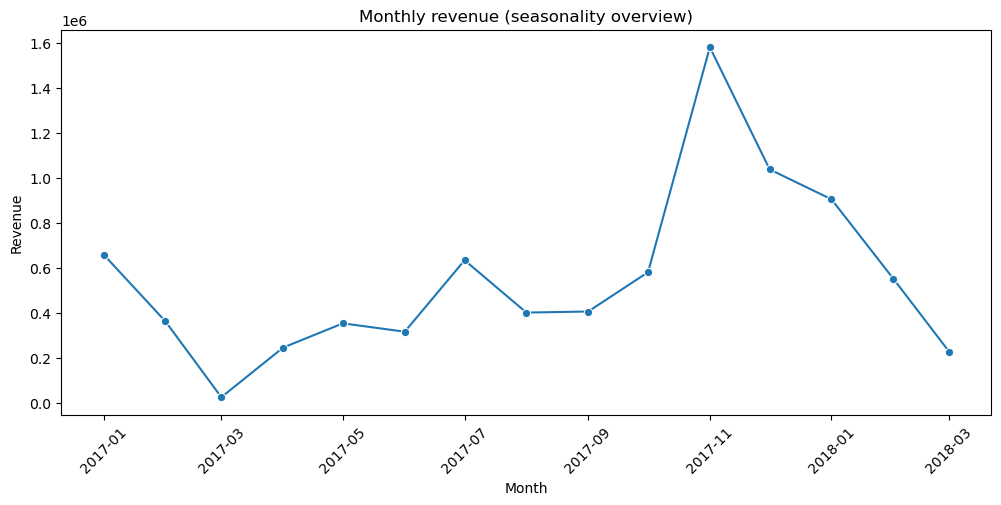

In [250]:
#create sales timeseries and baseline plots:
# Merge orderlines with orders to get created_date, and compute revenue per line
# Convert both unit_price and product_quantity to numeric values
orderlines_copy['unit_price'] = pd.to_numeric(orderlines_copy['unit_price'], errors='coerce')  # Convert to numeric, invalid values become NaN
orderlines_copy['product_quantity'] = pd.to_numeric(orderlines_copy['product_quantity'], errors='coerce')  # Convert to numeric

# Calculate line revenue after ensuring both columns are numeric
orderlines_copy['line_revenue'] = orderlines_copy['unit_price'] * orderlines_copy['product_quantity']

# Map to created_date from completed_orders
# completed_orders has 'order_id' and 'created_date'
sales = orderlines_copy.merge(completed_orders[['order_id','created_date']], left_on='id_order', right_on='order_id', how='left')
sales['date'] = sales['created_date'].dt.date  # date-only

# Daily revenue
daily = sales.groupby('date', as_index=False)['line_revenue'].sum().sort_values('date')

# plot daily revenue (time series)
plt.figure(figsize=(14,5))
sns.lineplot(data=daily, x='date', y='line_revenue')
plt.title('Daily revenue (sum of unit_price * qty)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

# monthly aggregation (helps visualize seasonality)
sales['month'] = sales['created_date'].dt.to_period('M')
monthly = sales.groupby('month')['line_revenue'].sum().reset_index()
monthly['month'] = monthly['month'].dt.to_timestamp()

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly, x='month', y='line_revenue', marker='o')
plt.title('Monthly revenue (seasonality overview)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

In [251]:
#Holiday uplift  (Black Friday & Christmas)
# helper: get black friday date for a year
def black_friday(year):
    fridays = pd.date_range(start=f'{year}-11-01', end=f'{year}-11-30', freq='W-FRI')
    # 4th friday in November (index 3)
    if len(fridays) >= 4:
        return fridays[3].date()
    else:
        return fridays[-1].date()

# analyze uplift for a given holiday function and window
def holiday_uplift(sales_df, holiday_dates, window=3, baseline_weeks=4):
    """
    For each holiday date (datetime.date), compute:
      revenue during holiday window (±window days),
      baseline = average revenue per same-length window in preceding baseline_weeks (week windows)
    Returns a small DataFrame with uplift pct.
    """
    results = []
    daily_revenue = sales_df.groupby('date')['line_revenue'].sum()
    for h in holiday_dates:
        start = h - pd.Timedelta(days=window)
        end = h + pd.Timedelta(days=window)
        window_rev = daily_revenue.loc[start:end].sum() if start in daily_revenue.index or end in daily_revenue.index else daily_revenue.loc[start:end].sum()
        # baseline: previous baseline_weeks * 7 days window length (same length as window_rev)
        baseline_periods = []
        for w in range(1, baseline_weeks+1):
            b_start = start - pd.Timedelta(days=7*w)
            b_end = end - pd.Timedelta(days=7*w)
            baseline_periods.append(daily_revenue.loc[b_start:b_end].sum())
        baseline_mean = np.nanmean(baseline_periods)
        uplift = (window_rev - baseline_mean) / baseline_mean * 100 if baseline_mean and (not np.isnan(baseline_mean)) else np.nan
        results.append({'holiday': h, 'window_rev': window_rev, 'baseline_mean': baseline_mean, 'uplift_pct': uplift})
    return pd.DataFrame(results)

# Build list of holiday dates in dataset years
years = completed_orders['created_date'].dt.year.unique()
black_fridays = [black_friday(int(y)) for y in years]
christmas_days = [pd.Timestamp(int(y),12,25).date() for y in years]

# Ensure sales['date'] is a datetime.date indexable series
sales_for_holiday = sales.copy()
sales_for_holiday['date'] = pd.to_datetime(sales_for_holiday['created_date'].dt.date)

bf_results = holiday_uplift(sales_for_holiday, black_fridays, window=3, baseline_weeks=4)
xmas_results = holiday_uplift(sales_for_holiday, christmas_days, window=7, baseline_weeks=4)  # Christmas window larger

print("Black Friday uplift per year:\n", bf_results)
print("Christmas uplift per year:\n", xmas_results)

Black Friday uplift per year:
       holiday  window_rev  baseline_mean  uplift_pct
0  2017-11-24  1151273.24      139015.09      728.16
1  2018-11-23        0.00           0.00         NaN
Christmas uplift per year:
       holiday  window_rev  baseline_mean  uplift_pct
0  2017-12-25   627083.59      712871.06      -12.03
1  2018-12-25        0.00           0.00         NaN


In [253]:
# Aggregate total quantity sold per day
daily_sales = orderlines_copy.groupby(orderlines['date'].dt.date)['product_quantity'].sum().reset_index()
daily_sales.rename(columns={'product_quantity':'total_qty'}, inplace=True)

# Convert back to datetime for plotting
daily_sales['date'] = pd.to_datetime(daily_sales['date'])

In [254]:
# Helper: compute Black Friday date for each year
def black_friday(year):
    fridays = pd.date_range(start=f'{year}-11-01', end=f'{year}-11-30', freq='W-FRI')
    return fridays[3] if len(fridays) >= 4 else fridays[-1]

# Build holiday date ranges
years = daily_sales['date'].dt.year.unique()
holiday_windows = []

for y in years:
    bf = black_friday(y)
    xmas = pd.Timestamp(y, 12, 25)
    
    # ±3 days for BF, ±7 for Xmas
    bf_range = pd.date_range(bf - pd.Timedelta(days=3), bf + pd.Timedelta(days=3))
    xmas_range = pd.date_range(xmas - pd.Timedelta(days=7), xmas + pd.Timedelta(days=7))
    
    holiday_windows.extend(bf_range)
    holiday_windows.extend(xmas_range)

# Flag holiday period
daily_sales['is_holiday'] = daily_sales['date'].isin(holiday_windows)

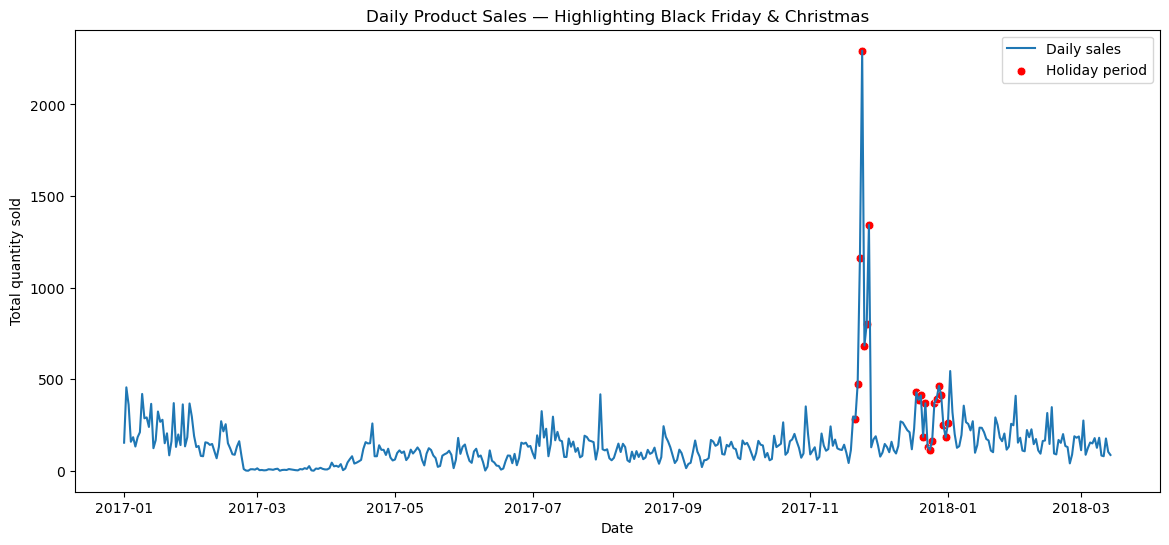

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.lineplot(data=daily_sales, x='date', y='total_qty', label='Daily sales')

# Highlight holiday windows
sns.scatterplot(data=daily_sales[daily_sales['is_holiday']], 
                x='date', y='total_qty', 
                color='red', s=40, label='Holiday period')

plt.title("Daily Product Sales — Highlighting Black Friday & Christmas")
plt.xlabel("Date")
plt.ylabel("Total quantity sold")
plt.legend()
plt.show()

In [257]:

# Merge orderlines with product info to know discount status
orderlines_merged = orderlines_copy.merge(product_category_df[['sku','price','promo_price']], on='sku', how='left')

# Flag discounted lines
orderlines_merged['is_discounted'] = (
    (orderlines_merged['promo_price'].notna()) &
    (orderlines_merged['price'].notna()) &
    (orderlines_merged['promo_price'] < orderlines_merged['price'])
)

In [258]:
daily_discounted = (
    orderlines_merged.groupby([orderlines_merged['date'].dt.date, 'is_discounted'])['product_quantity']
    .sum().reset_index()
)
daily_discounted.rename(columns={'product_quantity':'total_qty'}, inplace=True)
daily_discounted['date'] = pd.to_datetime(daily_discounted['date'])

In [259]:
daily_discounted['is_holiday'] = daily_discounted['date'].isin(holiday_windows)

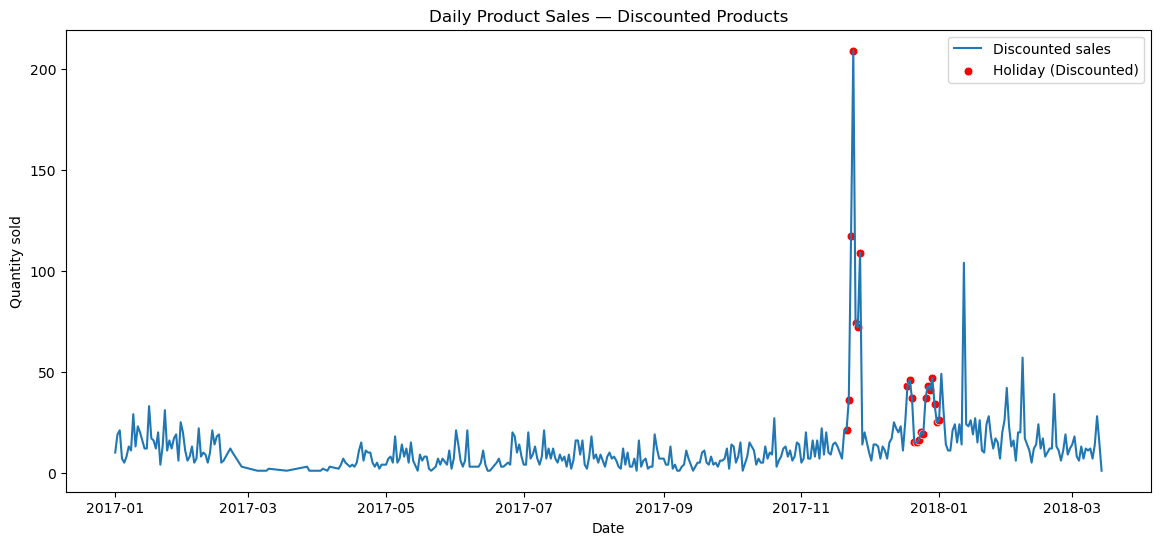

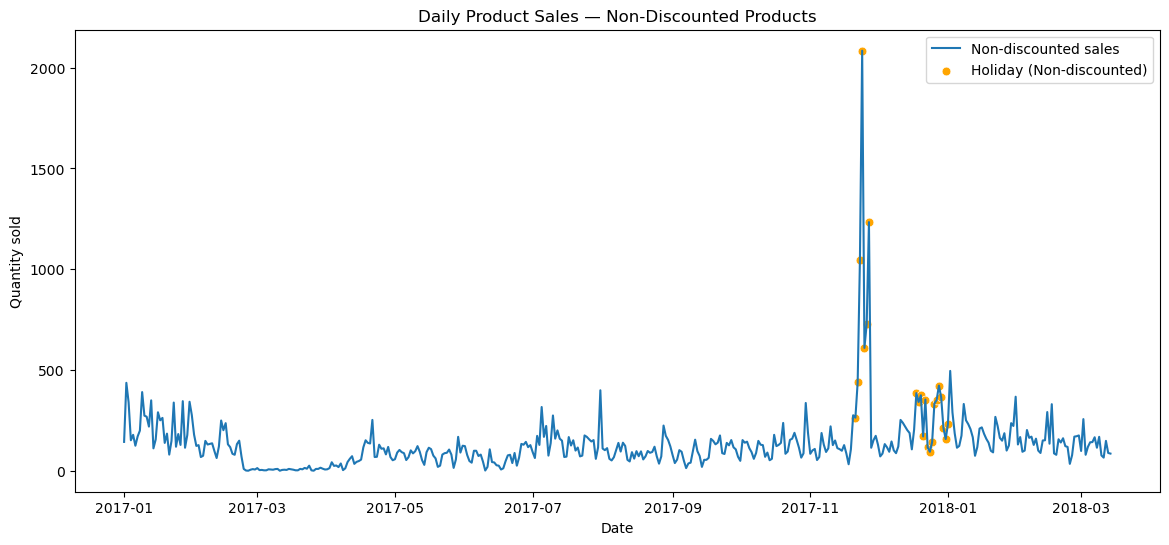

In [260]:
import seaborn as sns
import matplotlib.pyplot as plt

# Separate DataFrames
discounted_df = daily_discounted[daily_discounted['is_discounted']]
nondiscounted_df = daily_discounted[~daily_discounted['is_discounted']]

# Plot for discounted products
plt.figure(figsize=(14,6))
sns.lineplot(data=discounted_df, x='date', y='total_qty', label='Discounted sales')
sns.scatterplot(data=discounted_df[discounted_df['is_holiday']], 
                x='date', y='total_qty', color='red', s=40, label='Holiday (Discounted)')
plt.title("Daily Product Sales — Discounted Products")
plt.xlabel("Date")
plt.ylabel("Quantity sold")
plt.legend()
plt.show()

# Plot for non-discounted products
plt.figure(figsize=(14,6))
sns.lineplot(data=nondiscounted_df, x='date', y='total_qty', label='Non-discounted sales')
sns.scatterplot(data=nondiscounted_df[nondiscounted_df['is_holiday']], 
                x='date', y='total_qty', color='orange', s=40, label='Holiday (Non-discounted)')
plt.title("Daily Product Sales — Non-Discounted Products")
plt.xlabel("Date")
plt.ylabel("Quantity sold")
plt.legend()
plt.show()

In [261]:
# Group by holiday + discount flag
avg_sales = (
    daily_discounted
    .groupby(['is_discounted','is_holiday'])['total_qty']
    .mean()
    .reset_index()
)

print(avg_sales)

   is_discounted  is_holiday  total_qty
0          False       False     116.18
1          False        True     475.77
2           True       False      10.79
3           True        True      50.09


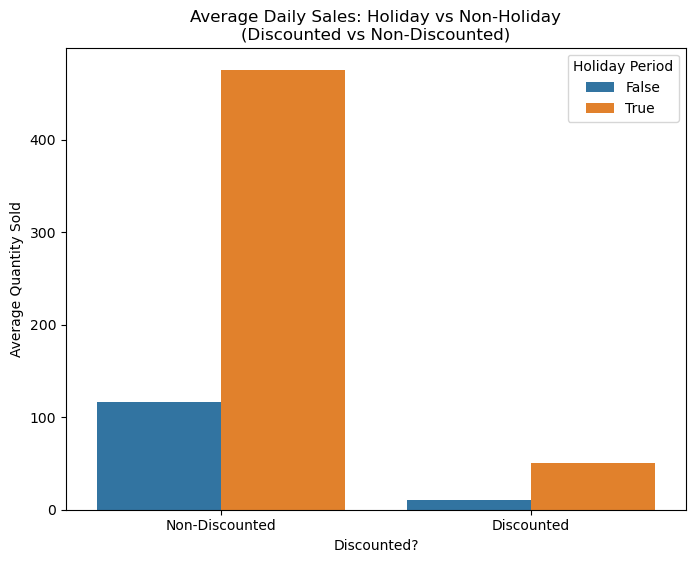

In [262]:
plt.figure(figsize=(8,6))
sns.barplot(data=avg_sales, x='is_discounted', y='total_qty', hue='is_holiday')

plt.title("Average Daily Sales: Holiday vs Non-Holiday\n(Discounted vs Non-Discounted)")
plt.xlabel("Discounted?")
plt.ylabel("Average Quantity Sold")
plt.xticks([0,1], ['Non-Discounted','Discounted'])
plt.legend(title="Holiday Period")
plt.show()